# Задание 1

**ОСНОВНАЯ ЦЕЛЬ:**

A/B-тестирование: анализ результатов эксперимента, которые зафиксированы в датасете data_ab.csv, — проверка наличия статистически и практически значимых различий между наблюдениями в контрольной и экспериментальной группах.

**ПЛАН**

По замыслу A/B-теста контрольной группе (control) должна была показываться старая версия лендинга — old_page; экспериментальной группе (treatment) должна была показываться новая версия лендинга — new_page.

1. понять структуру данных, провести **EDA** и **выбрать метрику**, с которой будете
работать;

2. проверить корректность проведения тестирования (посмотреть на однородность групп; задуматься об A/A тесте; не забыть, что в нашем распоряжении есть еще и временные метки);

3. **сформулировать нулевую и альтернативную гипотезы** на основании выбранной метрики;

4. выбрать и обосновать статистический тест;
решить, нужно ли устаналивать значения каких-либо параметров до начала анализа тестирования;
5. оценить разницу в результатах и сделать выводы о практической значимости эксперимента;
6. провести дополнительный анализ при необходимости (например, с помощью bootstrap или через анализ чувствительности);
7. сформулировать рекомендации и **бизнес-инсайты** по результатам эксперимента.

**учёта в значительной степени временной составляющей эксперимента.**

обоснованного применения дополнительных инструментов/подходов для анализа результатов A/B-тестирования, не упомянутых ранее в этом ноутбуке и не рассматривавшихся в рамках соответствующего семинара и лекции (**bootstrap'a или анализа чувствительности** может хватить на 3 балла при условии корректного и осмысленного их применения).

In [796]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import scipy as sc

## EDA

### Скачиваем

In [797]:
df = pd.read_csv("data_ab.csv")
df

,user_id,timestamp,group,landing_page,converted
0,851104,2025-01-21 22:11:48.556739,control,old_page,0
1,804228,2025-01-12 08:01:45.159739,control,old_page,0
2,661590,2025-01-11 16:55:06.154213,treatment,new_page,0
3,853541,2025-01-08 18:28:03.143765,treatment,new_page,0
4,864975,2025-01-21 01:52:26.210827,control,old_page,1
...,...,...,...,...,...
294473,751197,2025-01-03 22:28:38.630509,control,old_page,0
294474,945152,2025-01-12 00:51:57.078372,control,old_page,0
294475,734608,2025-01-22 11:45:03.439544,control,old_page,0
294476,697314,2025-01-15 01:20:28.957438,control,old_page,0


In [798]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 294478 entries, 0 to 294477
Data columns (total 5 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   user_id       294478 non-null  int64 
 1   timestamp     294478 non-null  object
 2   group         294478 non-null  object
 3   landing_page  294478 non-null  object
 4   converted     294478 non-null  int64 
dtypes: int64(2), object(3)
memory usage: 11.2+ MB


у нас timestamp имеет тип объекта object, что неверно, ведь это дата

сразу исправим

In [799]:
df["timestamp"] = pd.to_datetime(df["timestamp"])

In [800]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 294478 entries, 0 to 294477
Data columns (total 5 columns):
 #   Column        Non-Null Count   Dtype         
---  ------        --------------   -----         
 0   user_id       294478 non-null  int64         
 1   timestamp     294478 non-null  datetime64[ns]
 2   group         294478 non-null  object        
 3   landing_page  294478 non-null  object        
 4   converted     294478 non-null  int64         
dtypes: datetime64[ns](1), int64(2), object(2)
memory usage: 11.2+ MB


### Чистим дубликаты

In [801]:
print(f"Изначально: {len(df)}")

df_no_full_dupes = df.drop_duplicates()
rows1 = df_no_full_dupes.shape[0]
print(f"После удаления полных дублей: {rows1}")

Изначально: 294478
После удаления полных дублей: 294478


полных дубликатов нет, чек дубликаты по user

In [802]:
dupes_id = df["user_id"].value_counts()
dupes_id

,count
user_id,
752737,2
781280,2
767913,2
886060,2
731779,2
...,...
653383,1
732573,1
867433,1


In [803]:
dupes_id = dupes_id[dupes_id > 1].index
dupes_rows = df[df["user_id"].isin(dupes_id)]
df2 = dupes_rows.sort_values(by="user_id")

df2

,user_id,timestamp,group,landing_page,converted
213114,630052,2025-01-07 12:25:54.089486,treatment,old_page,1
230259,630052,2025-01-17 01:16:05.208766,treatment,new_page,0
251762,630126,2025-01-19 17:16:00.280440,treatment,new_page,0
22513,630126,2025-01-14 13:35:54.778695,treatment,old_page,0
11792,630137,2025-01-22 14:59:22.051308,control,new_page,0
...,...,...,...,...,...
99479,945703,2025-01-18 06:39:31.294688,control,old_page,0
186960,945797,2025-01-13 17:23:21.750962,control,old_page,0
40370,945797,2025-01-11 03:04:49.433736,control,new_page,1
165143,945971,2025-01-16 10:09:18.383183,control,old_page,0


видим, что есть строки, где у user treatment и old_page и new_page и ан-но control

In [804]:
df2.groupby(["group", "landing_page"]).size()

group      landing_page
control    new_page        1928
           old_page        1981
treatment  new_page        1914
           old_page        1965
dtype: int64

у control должно быть old_page, а у treatment - new_page по усл

поместим неправильные в отд датасет

In [805]:
mask = (
    ((df["group"] == "treatment") & (df["landing_page"] == "old_page")) |
    ((df["group"] == "control") & (df["landing_page"] == "new_page"))
)

df_mist = df[mask]

In [806]:
df_mist.sort_values("timestamp")

,user_id,timestamp,group,landing_page,converted
291728,828985,2025-01-02 13:55:08.790046,control,new_page,0
167601,787103,2025-01-02 14:03:33.543019,control,new_page,0
194773,694909,2025-01-02 14:05:08.848519,control,new_page,0
23279,750558,2025-01-02 14:06:46.989262,control,new_page,0
146523,762515,2025-01-02 14:44:53.517658,control,new_page,0
...,...,...,...,...,...
51862,709466,2025-01-24 12:56:11.808544,control,new_page,0
39395,732074,2025-01-24 13:04:22.448451,control,new_page,0
170943,797801,2025-01-24 13:12:58.139993,treatment,old_page,0
228167,670745,2025-01-24 13:25:28.589447,control,new_page,0


In [807]:
df_clean = df[~mask]
df_clean

,user_id,timestamp,group,landing_page,converted
0,851104,2025-01-21 22:11:48.556739,control,old_page,0
1,804228,2025-01-12 08:01:45.159739,control,old_page,0
2,661590,2025-01-11 16:55:06.154213,treatment,new_page,0
3,853541,2025-01-08 18:28:03.143765,treatment,new_page,0
4,864975,2025-01-21 01:52:26.210827,control,old_page,1
...,...,...,...,...,...
294473,751197,2025-01-03 22:28:38.630509,control,old_page,0
294474,945152,2025-01-12 00:51:57.078372,control,old_page,0
294475,734608,2025-01-22 11:45:03.439544,control,old_page,0
294476,697314,2025-01-15 01:20:28.957438,control,old_page,0


проверим нет ли больше дубликатов

In [808]:
dupes_id = df_clean["user_id"].value_counts()
dupes_id = dupes_id[dupes_id > 1]

dupes_id

,count
user_id,
773192,2


In [809]:
df_clean[df_clean["user_id"] == 773192]

,user_id,timestamp,group,landing_page,converted
1899,773192,2025-01-09 05:37:58.781806,treatment,new_page,0
2893,773192,2025-01-14 02:55:59.590927,treatment,new_page,0


чел заходил 2 раза на сайт и оба раза не зарегался, поэтому удалим один из его заходов, так как не влияет

In [810]:
idx = df_clean[df_clean["user_id"] == 773192].index[0]
df_clean = df_clean.drop(idx)

In [811]:
df = df_clean
df

,user_id,timestamp,group,landing_page,converted
0,851104,2025-01-21 22:11:48.556739,control,old_page,0
1,804228,2025-01-12 08:01:45.159739,control,old_page,0
2,661590,2025-01-11 16:55:06.154213,treatment,new_page,0
3,853541,2025-01-08 18:28:03.143765,treatment,new_page,0
4,864975,2025-01-21 01:52:26.210827,control,old_page,1
...,...,...,...,...,...
294473,751197,2025-01-03 22:28:38.630509,control,old_page,0
294474,945152,2025-01-12 00:51:57.078372,control,old_page,0
294475,734608,2025-01-22 11:45:03.439544,control,old_page,0
294476,697314,2025-01-15 01:20:28.957438,control,old_page,0


### Пропуски чекаем (их нет)

In [812]:
df.isna().sum()

,0
user_id,0
timestamp,0
group,0
landing_page,0
converted,0


### чек ошибочные (нет)

In [813]:
df.head()

,user_id,timestamp,group,landing_page,converted
0,851104,2025-01-21 22:11:48.556739,control,old_page,0
1,804228,2025-01-12 08:01:45.159739,control,old_page,0
2,661590,2025-01-11 16:55:06.154213,treatment,new_page,0
3,853541,2025-01-08 18:28:03.143765,treatment,new_page,0
4,864975,2025-01-21 01:52:26.210827,control,old_page,1


In [814]:
print(df["group"].unique())
print(df["landing_page"].unique())
print(df["converted"].unique())

['control' 'treatment']
['old_page' 'new_page']
[0 1]


нет ошибочных

### чек выбросы и распределения каждого признака

нет выбросов, все распределено равномерно

#### timestamp

посмотрим на столбец timestamp

In [815]:
df["date"] = df["timestamp"].dt.date
df["hour"] = df["timestamp"].dt.hour

df.head()

,user_id,timestamp,group,landing_page,converted,date,hour
0,851104,2025-01-21 22:11:48.556739,control,old_page,0,2025-01-21,22
1,804228,2025-01-12 08:01:45.159739,control,old_page,0,2025-01-12,8
2,661590,2025-01-11 16:55:06.154213,treatment,new_page,0,2025-01-11,16
3,853541,2025-01-08 18:28:03.143765,treatment,new_page,0,2025-01-08,18
4,864975,2025-01-21 01:52:26.210827,control,old_page,1,2025-01-21,1


In [816]:
df = df.sort_values("timestamp")
df

,user_id,timestamp,group,landing_page,converted,date,hour
131228,922696,2025-01-02 13:42:05.378582,treatment,new_page,0,2025-01-02,13
184884,781507,2025-01-02 13:42:15.234051,control,old_page,0,2025-01-02,13
83878,737319,2025-01-02 13:42:21.786186,control,old_page,0,2025-01-02,13
102717,818377,2025-01-02 13:42:26.640581,treatment,new_page,0,2025-01-02,13
158789,725857,2025-01-02 13:42:27.851110,treatment,new_page,0,2025-01-02,13
...,...,...,...,...,...,...,...
158814,799244,2025-01-24 13:41:15.325359,treatment,new_page,0,2025-01-24,13
47535,808330,2025-01-24 13:41:19.152664,control,old_page,0,2025-01-24,13
157787,843121,2025-01-24 13:41:44.097174,treatment,new_page,0,2025-01-24,13
179072,836373,2025-01-24 13:41:52.604673,control,old_page,0,2025-01-24,13


так как вы видим, что у нас один год - 2025 и один месяц - январь, то нас интересует по сути только день и можно еще посмотреть день недели

In [817]:
df["day"] = df["timestamp"].dt.day
df.head()

,user_id,timestamp,group,landing_page,converted,date,hour,day
131228,922696,2025-01-02 13:42:05.378582,treatment,new_page,0,2025-01-02,13,2
184884,781507,2025-01-02 13:42:15.234051,control,old_page,0,2025-01-02,13,2
83878,737319,2025-01-02 13:42:21.786186,control,old_page,0,2025-01-02,13,2
102717,818377,2025-01-02 13:42:26.640581,treatment,new_page,0,2025-01-02,13,2
158789,725857,2025-01-02 13:42:27.851110,treatment,new_page,0,2025-01-02,13,2


In [818]:
df["weekday_num"] = df["timestamp"].dt.weekday
df

,user_id,timestamp,group,landing_page,converted,date,hour,day,weekday_num
131228,922696,2025-01-02 13:42:05.378582,treatment,new_page,0,2025-01-02,13,2,3
184884,781507,2025-01-02 13:42:15.234051,control,old_page,0,2025-01-02,13,2,3
83878,737319,2025-01-02 13:42:21.786186,control,old_page,0,2025-01-02,13,2,3
102717,818377,2025-01-02 13:42:26.640581,treatment,new_page,0,2025-01-02,13,2,3
158789,725857,2025-01-02 13:42:27.851110,treatment,new_page,0,2025-01-02,13,2,3
...,...,...,...,...,...,...,...,...,...
158814,799244,2025-01-24 13:41:15.325359,treatment,new_page,0,2025-01-24,13,24,4
47535,808330,2025-01-24 13:41:19.152664,control,old_page,0,2025-01-24,13,24,4
157787,843121,2025-01-24 13:41:44.097174,treatment,new_page,0,2025-01-24,13,24,4
179072,836373,2025-01-24 13:41:52.604673,control,old_page,0,2025-01-24,13,24,4


In [819]:
df["weekday_num"].value_counts()

,count
weekday_num,
4,47148
3,45439
2,39915
1,39670
0,39626
5,39565
6,39221


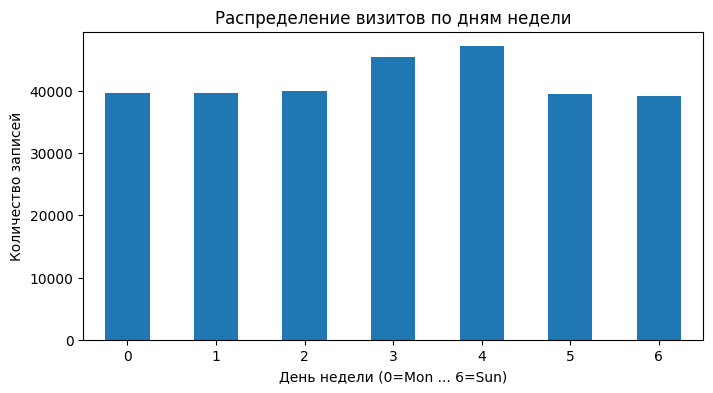

In [820]:
weekday_counts = df["weekday_num"].value_counts().sort_index()

plt.figure(figsize=(8,4))
weekday_counts.plot(kind="bar")

plt.xlabel("День недели (0=Mon ... 6=Sun)")
plt.ylabel("Количество записей")
plt.title("Распределение визитов по дням недели")
plt.xticks(rotation=0)
plt.show()

In [821]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 290584 entries, 131228 to 193652
Data columns (total 9 columns):
 #   Column        Non-Null Count   Dtype         
---  ------        --------------   -----         
 0   user_id       290584 non-null  int64         
 1   timestamp     290584 non-null  datetime64[ns]
 2   group         290584 non-null  object        
 3   landing_page  290584 non-null  object        
 4   converted     290584 non-null  int64         
 5   date          290584 non-null  object        
 6   hour          290584 non-null  int32         
 7   day           290584 non-null  int32         
 8   weekday_num   290584 non-null  int32         
dtypes: datetime64[ns](1), int32(3), int64(2), object(3)
memory usage: 18.8+ MB


In [822]:
df["timestamp"].describe()

,timestamp
count,290584
mean,2025-01-13 13:42:03.906819584
min,2025-01-02 13:42:05.378582
25%,2025-01-08 02:06:43.829340672
50%,2025-01-13 13:21:45.577577728
75%,2025-01-19 01:49:46.966643968
max,2025-01-24 13:41:54.460509


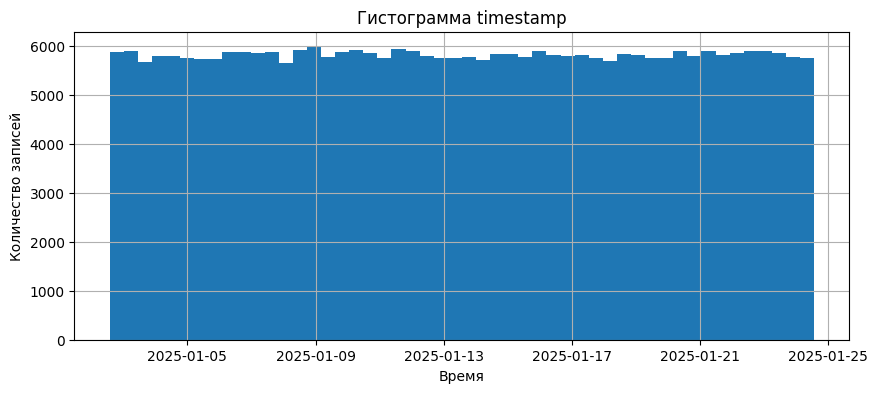

In [823]:
plt.figure(figsize=(10,4))
df["timestamp"].hist(bins=50)
plt.xlabel("Время")
plt.ylabel("Количество записей")
plt.title("Гистограмма timestamp")
plt.show()

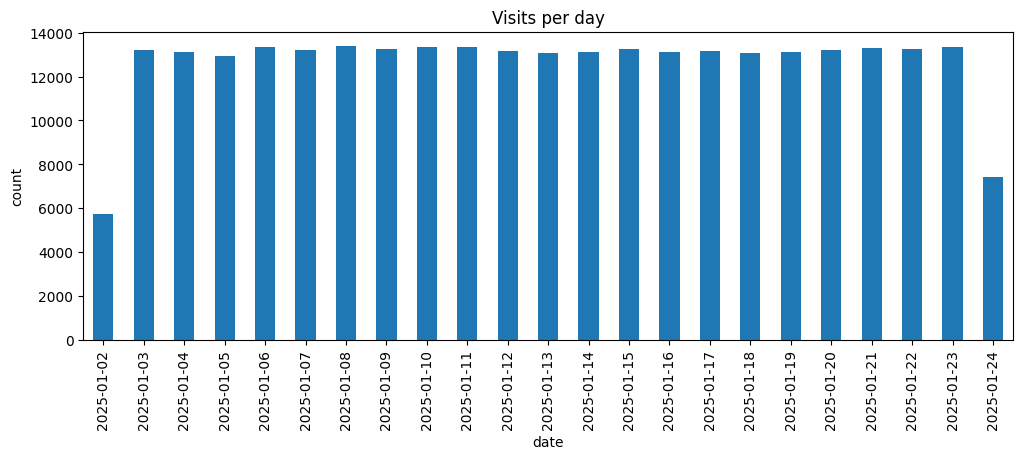

In [824]:
date_counts = df["date"].value_counts().sort_index()

date_counts.plot(kind="bar", figsize=(12,4))
plt.xlabel("date")
plt.ylabel("count")
plt.title("Visits per day")
plt.show()

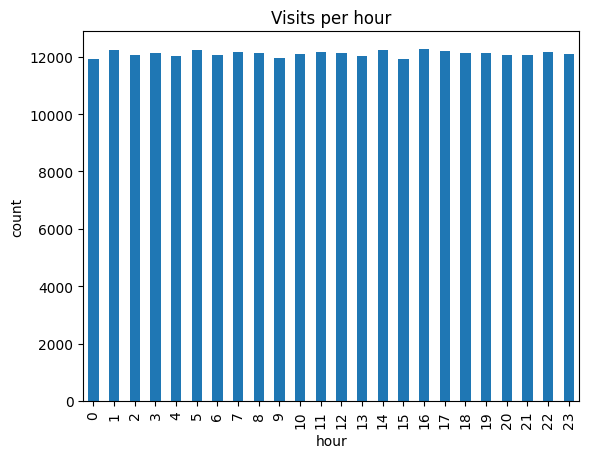

In [825]:
hour_counts = df["hour"].value_counts().sort_index()

hour_counts.plot(kind="bar")
plt.xlabel("hour")
plt.ylabel("count")
plt.title("Visits per hour")
plt.show()

время распределено в целом равномерно, нет никаких выбросов

#### group и landing_page

так как мы оставили, что каждой группе соответствует своя страница, то у них совпадают распределния

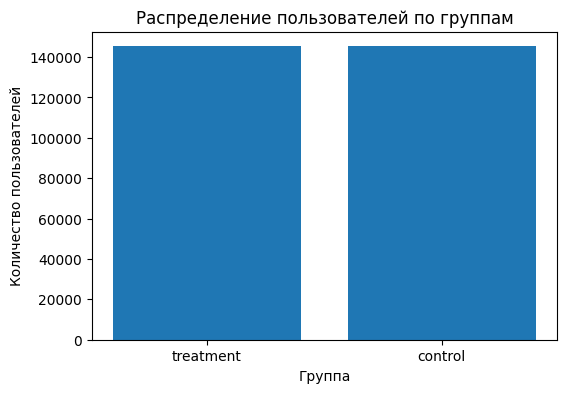

In [826]:
group_counts = df_clean["group"].value_counts()

plt.figure(figsize=(6,4))
plt.bar(group_counts.index, group_counts.values)

plt.xlabel("Группа")
plt.ylabel("Количество пользователей")
plt.title("Распределение пользователей по группам")

plt.show()

#### converted

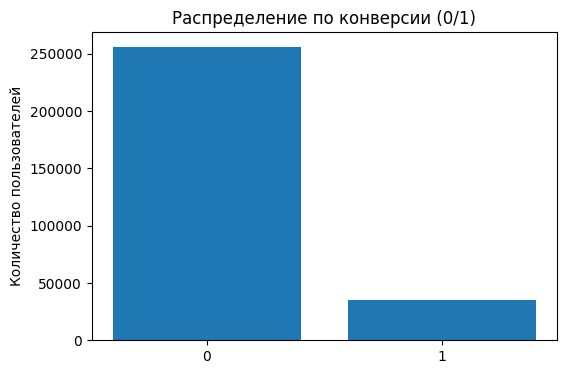

In [827]:
counts = df_clean["converted"].value_counts().sort_index()
labels = ["0", "1"]

plt.figure(figsize=(6,4))
plt.bar(labels, counts.values)

plt.ylabel("Количество пользователей")
plt.title("Распределение по конверсии (0/1)")
plt.show()

### fe

удалим ненужные столбцы

In [828]:
df = df.drop(columns=["user_id", "timestamp", "landing_page", "date"])
df.head()

,group,converted,hour,day,weekday_num
131228,treatment,0,13,2,3
184884,control,0,13,2,3
83878,control,0,13,2,3
102717,treatment,0,13,2,3
158789,treatment,0,13,2,3


особых зависимотсей не выявлено

## ВЫБОР МЕТРИКИ

Ключевая метрика - конверсия, потому что именно она отражает, что нам важно в этом A/B-тесте: какая доля пользователей совершила целевое действие. Все изменения в продукте оцениваются через изменение конверсии.

#### Связь метрики с другими признаками

In [829]:
df_conv1 = df[df["converted"] == 1]

In [830]:
df_conv1.info()

<class 'pandas.core.frame.DataFrame'>
Index: 34753 entries, 126997 to 260161
Data columns (total 5 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   group        34753 non-null  object
 1   converted    34753 non-null  int64 
 2   hour         34753 non-null  int32 
 3   day          34753 non-null  int32 
 4   weekday_num  34753 non-null  int32 
dtypes: int32(3), int64(1), object(1)
memory usage: 1.2+ MB


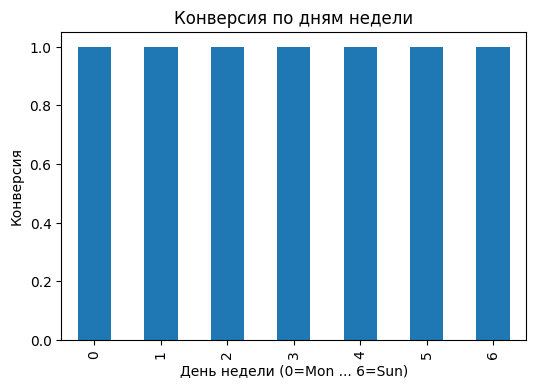

In [831]:
import matplotlib.pyplot as plt

conv_by_weekday = (
    df_conv1.groupby("weekday_num")["converted"]
      .mean()
      .sort_index()
)

plt.figure(figsize=(6,4))
conv_by_weekday.plot(kind="bar")
plt.xlabel("День недели (0=Mon ... 6=Sun)")
plt.ylabel("Конверсия")
plt.title("Конверсия по дням недели")
plt.show()

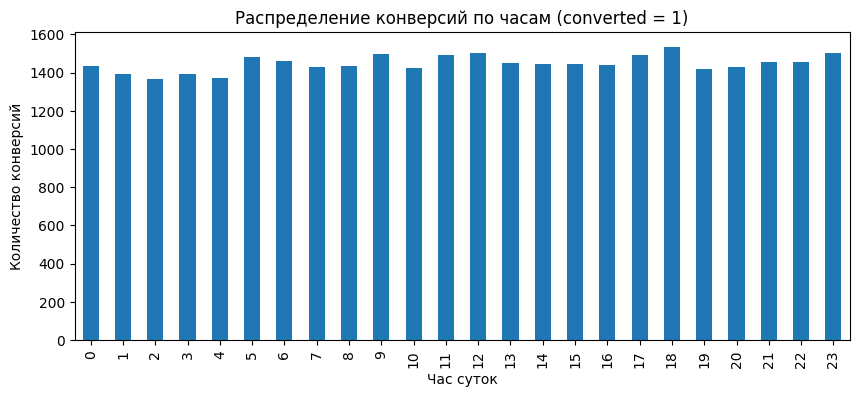

In [832]:
hour_counts = (
    df_conv1["hour"]
    .value_counts()
    .sort_index()
)

plt.figure(figsize=(10,4))
hour_counts.plot(kind="bar")
plt.xlabel("Час суток")
plt.ylabel("Количество конверсий")
plt.title("Распределение конверсий по часам (converted = 1)")
plt.show()

## КОРРЕКТНОСТЬ ПРОВЕДЕНИЯ ТЕСТИРОВАНИЯ

#### разбиваем на группы

In [833]:
gra = df[df["group"] == "control"]
grb = df[df["group"] == "treatment"]

In [834]:
gra = gra.drop(columns="group").reset_index(drop=True)
gra

,converted,hour,day,weekday_num
0,0,13,2,3
1,0,13,2,3
2,0,13,2,3
3,1,13,2,3
4,0,13,2,3
...,...,...,...,...
145269,1,13,24,4
145270,0,13,24,4
145271,0,13,24,4
145272,0,13,24,4


In [835]:
grb = grb.drop(columns="group").reset_index(drop=True)
grb

,converted,hour,day,weekday_num
0,0,13,2,3
1,0,13,2,3
2,0,13,2,3
3,0,13,2,3
4,0,13,2,3
...,...,...,...,...
145305,0,13,24,4
145306,0,13,24,4
145307,0,13,24,4
145308,0,13,24,4


In [836]:
print(len(gra))
print(len(grb))

145274
145310


#### однородность групп (распределения по признакам) (да)

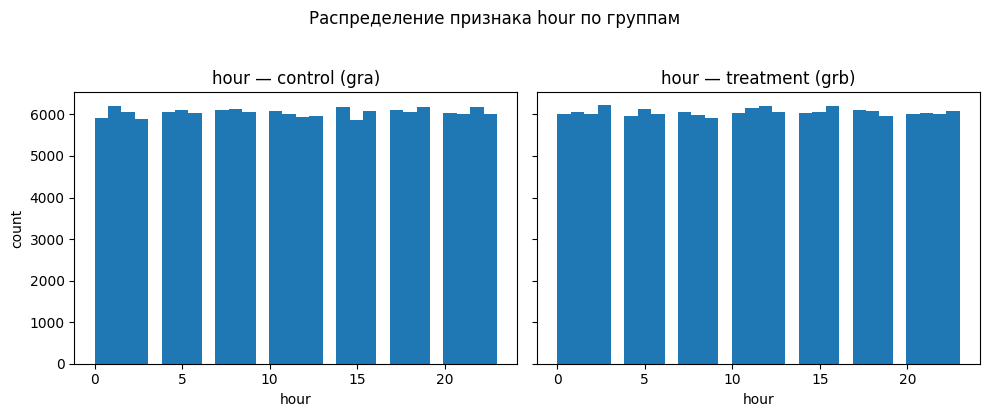

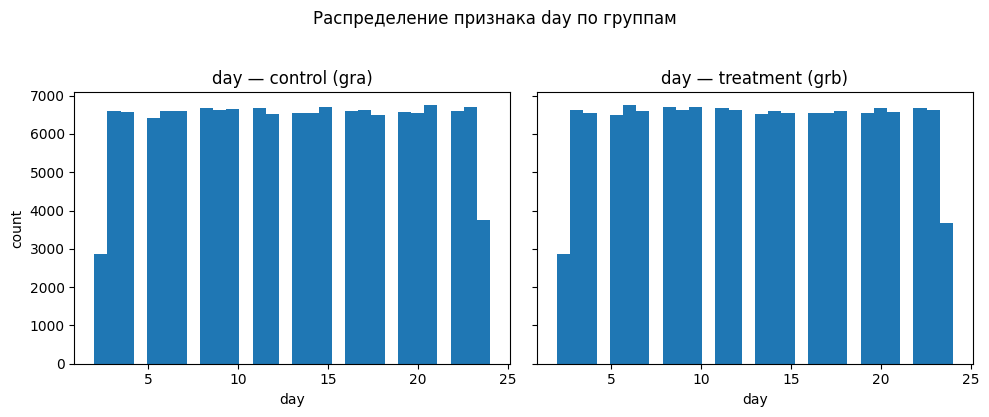

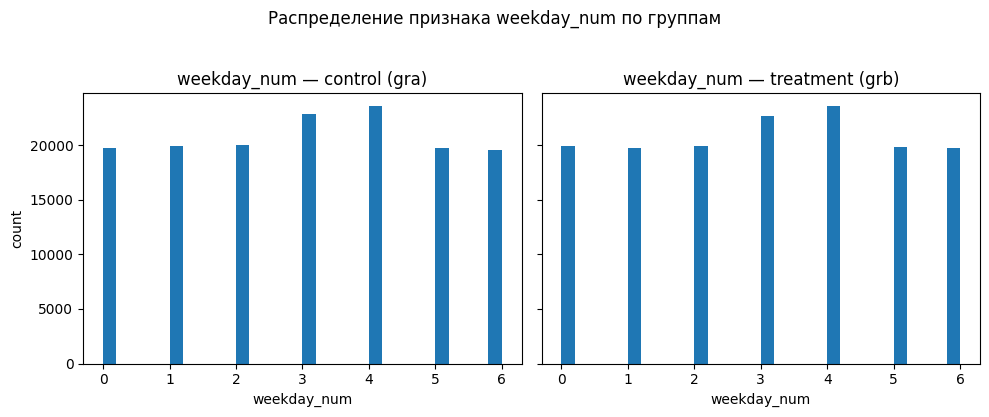

In [837]:
cols = ["hour", "day", "weekday_num"]

for col in cols:
    fig, axes = plt.subplots(1, 2, figsize=(10, 4), sharey=True)

    axes[0].hist(gra[col], bins=30)
    axes[0].set_title(f"{col} — control (gra)")
    axes[0].set_xlabel(col)
    axes[0].set_ylabel("count")

    axes[1].hist(grb[col], bins=30)
    axes[1].set_title(f"{col} — treatment (grb)")
    axes[1].set_xlabel(col)

    fig.suptitle(f"Распределение признака {col} по группам", y=1.03)
    plt.tight_layout()
    plt.show()

In [838]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 290584 entries, 131228 to 193652
Data columns (total 5 columns):
 #   Column       Non-Null Count   Dtype 
---  ------       --------------   ----- 
 0   group        290584 non-null  object
 1   converted    290584 non-null  int64 
 2   hour         290584 non-null  int32 
 3   day          290584 non-null  int32 
 4   weekday_num  290584 non-null  int32 
dtypes: int32(3), int64(1), object(1)
memory usage: 10.0+ MB


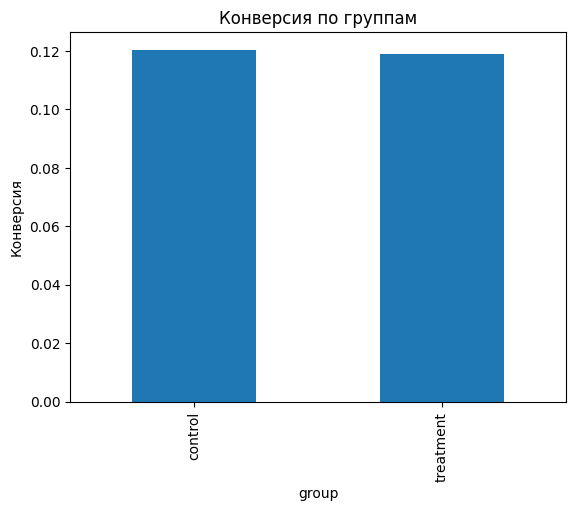

In [839]:
conv_by_group = df.groupby("group")["converted"].mean()

conv_by_group.plot(kind="bar")
plt.ylabel("Конверсия")
plt.title("Конверсия по группам")
plt.show()

группы по признакам однородны

#### сравнение связей метрики с параметрами по группам

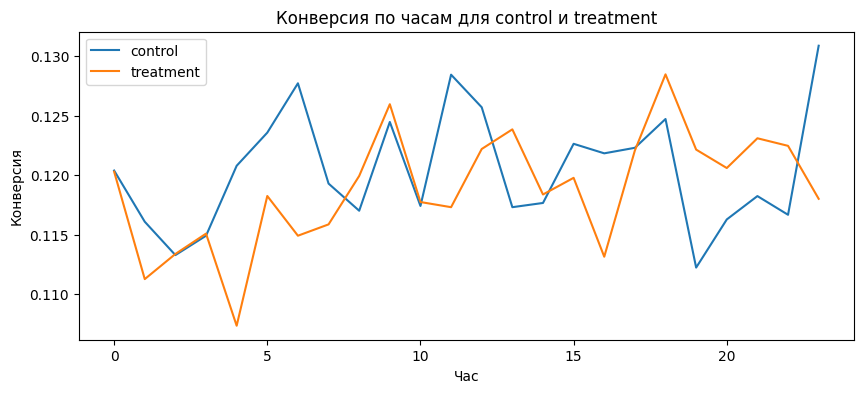

In [840]:
conv_hour_gra = gra.groupby("hour")["converted"].mean()
conv_hour_grb = grb.groupby("hour")["converted"].mean()

plt.figure(figsize=(10,4))
plt.plot(conv_hour_gra.index, conv_hour_gra.values, label="control")
plt.plot(conv_hour_grb.index, conv_hour_grb.values, label="treatment")
plt.xlabel("Час")
plt.ylabel("Конверсия")
plt.title("Конверсия по часам для control и treatment")
plt.legend()
plt.show()

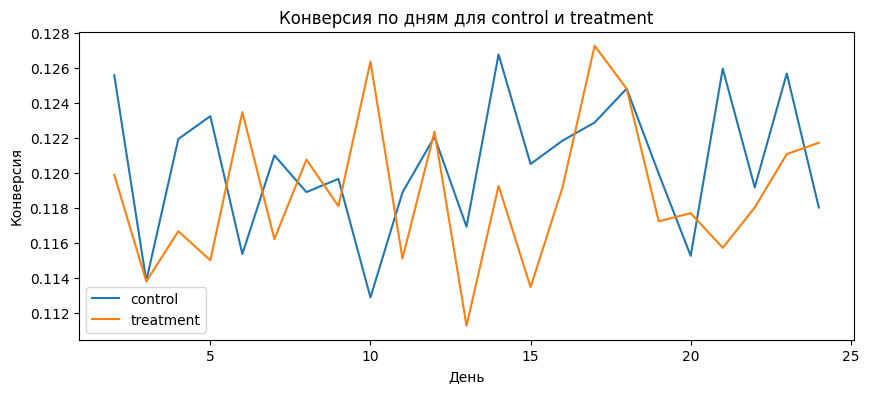

In [841]:
conv_hour_gra = gra.groupby("day")["converted"].mean()
conv_hour_grb = grb.groupby("day")["converted"].mean()

plt.figure(figsize=(10,4))
plt.plot(conv_hour_gra.index, conv_hour_gra.values, label="control")
plt.plot(conv_hour_grb.index, conv_hour_grb.values, label="treatment")
plt.xlabel("День")
plt.ylabel("Конверсия")
plt.title("Конверсия по дням для control и treatment")
plt.legend()
plt.show()

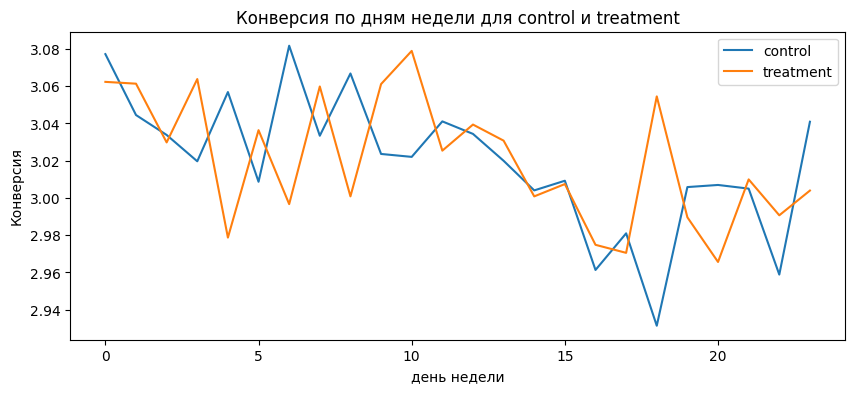

In [842]:
conv_hour_gra = gra.groupby("hour")["weekday_num"].mean()
conv_hour_grb = grb.groupby("hour")["weekday_num"].mean()

plt.figure(figsize=(10,4))
plt.plot(conv_hour_gra.index, conv_hour_gra.values, label="control")
plt.plot(conv_hour_grb.index, conv_hour_grb.values, label="treatment")
plt.xlabel("день недели")
plt.ylabel("Конверсия")
plt.title("Конверсия по дням недели для control и treatment")
plt.legend()
plt.show()

Проблема была бы, если бы:

	•	treatment стабильно выше control во всех часах/днях, тогда это просто “эффект теста”;
  
	•	или наоборот: до запуска фичи (в префиксном периоде) treatment уже был сильно выше/ниже - тогда это баг рандомизации.

### AA тест (подтвердили сплит система сработала хорошо)

**ДЛЯ КОНТРОЛЬНОЙ ГРУППЫ**

метрика - бинарная (конверсия), поэтому используем X^2 тест

In [843]:
from scipy.stats import chi2_contingency

def aa_test1(df):
    mask = np.random.rand(len(df)) < 0.5
    g1 = df[mask]
    g2 = df[~mask]

    cont = pd.crosstab(
        pd.concat([pd.Series(0, index=g1.index),
                   pd.Series(1, index=g2.index)]),
        df.loc[g1.index.union(g2.index), "converted"]
    )

    chi2, p, dof, expected = chi2_contingency(cont)
    return p

In [844]:
p_values = []

for i in range(1000):
    p = aa_test1(gra)
    p_values.append(p)

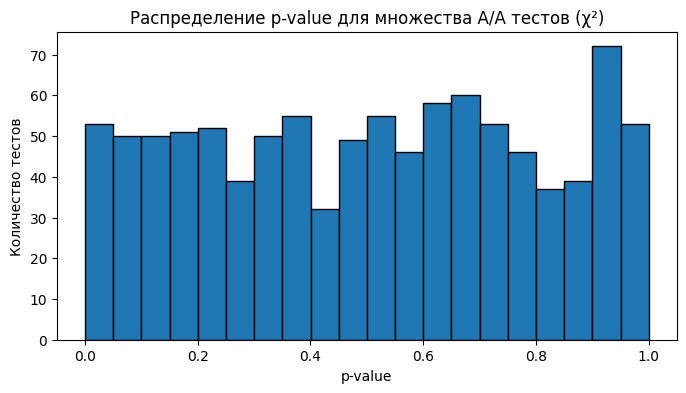

In [845]:
plt.figure(figsize=(8, 4))
plt.hist(p_values, bins=20, edgecolor="black")
plt.title("Распределение p-value для множества A/A тестов (χ²)")
plt.xlabel("p-value")
plt.ylabel("Количество тестов")
plt.show()

столбики по всему диапазону 0–1 примерно одинаковой высоты, т е p-value распределены равномерно, это значит, что сплит система работает правильно с точки зрения ошибки 1 рода

## ГИПОТЕЗЫ

H0 (нулевая гипотеза) - Средняя конверсия (доля пользователей, совершивших целевое действие) в контрольной и тестовой группе одинакова

H1 (альтернативная гипотеза) - Средняя конверсия в тестовой группе отличается от конверсии в контрольной группе.


# ПАРАМЕТРЫ КОТОРЫЕ ДОЛЖНЫ БЫТЬ ОПРЕДЕЛЕНЫ ЗАРАНЕЕ

**Уровень значимости (α) = 0,05**

Это вероятность ошибки первого рода - ситуации, когда мы ошибочно отвергаем нулевую гипотезу (то есть считаем, что есть эффект, хотя его нет)

**β = 0,2**

Это вероятность ошибки второго рода, то есть вероятность того, что мы не заметим эффект, даже если он на самом деле есть

**Мощность (1 − β) = 0,8**

Это вероятность обнаружить реальный эффект, если он действительно существует.


мощность показывает, с какой вероятностью тест правильно отвергнет нулевую гипотезу в ситуации, когда она неверна.

# СТАТИСТИЧЕСКИЙ ТЕСТ

метрика - бинарная (конверсия), поэтому используем X^2 тест

In [846]:
c_table = np.array([
    [
        (gra["converted"] == 0).sum(),
        (gra["converted"] == 1).sum(),
    ],
    [
        (grb["converted"] == 0).sum(),
        (grb["converted"] == 1).sum(),
    ]
])

print(c_table)

[[127785  17489]
 [128046  17264]]


In [847]:
from scipy.stats import chi2_contingency

chi2_contingency(c_table)

Chi2ContingencyResult(statistic=np.float64(1.7035660051885058), pvalue=np.float64(0.19182228096235662), dof=1, expected_freq=array([[127899.65274757,  17374.34725243],
       [127931.34725243,  17378.65274757]]))

У нас нет оснований отвергнуть нулевую гипотезу (pvalue = 0.2 > 0.05)

Статистически значимой разницы конверсии между control и treatment по данным этого эксперимента не обнаружено

# bootstrap

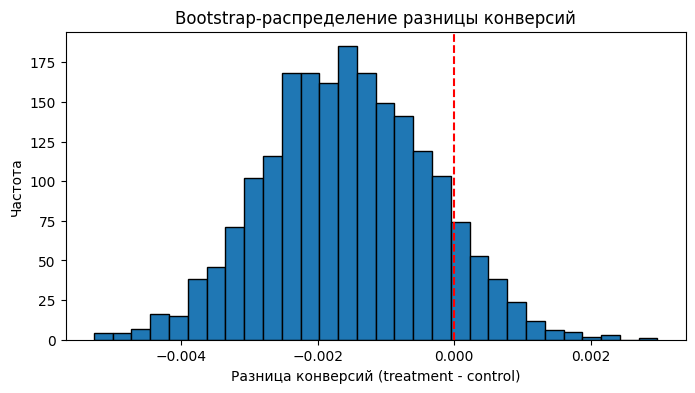

In [848]:
n_boot = 2000
boot_diffs = []

for _ in range(n_boot):
    sample_c = gra.sample(frac=1, replace=True)
    sample_t = grb.sample(frac=1, replace=True)

    p_c_b = sample_c["converted"].mean()
    p_t_b = sample_t["converted"].mean()

    boot_diffs.append(p_t_b - p_c_b)

boot_diffs = np.array(boot_diffs)

plt.figure(figsize=(8,4))
plt.hist(boot_diffs, bins=30, edgecolor="black")
plt.axvline(0, color="red", linestyle="--")
plt.xlabel("Разница конверсий (treatment - control)")
plt.ylabel("Частота")
plt.title("Bootstrap-распределение разницы конверсий")
plt.show()

Результаты бутстрап-оценки показывают, что 95% доверительный интервал для разницы конверсий между группами составляет от –0.0039 до 0.00075. Этот интервал включает ноль, что говорит об отсутствии статистически значимых различий между группами. Полученные выводы согласуются с классическим Z-тестом: эффект неустойчив, группы ведут себя одинаково.

# Анализ чувствительности (Sensitivity analysis)

In [849]:
from statsmodels.stats.proportion import proportions_ztest

sizes = np.linspace(0.2, 1.0, 10)
pvals = []

for s in sizes:
    nA = int(len(gra) * s)
    nB = int(len(grb) * s)

    partA = gra.sample(nA, random_state=1)
    partB = grb.sample(nB, random_state=1)

    count = [partA["converted"].sum(), partB["converted"].sum()]
    nobs = [len(partA), len(partB)]

    stat, p = proportions_ztest(count, nobs)
    pvals.append(p)

pvals

[np.float64(0.16472626123530476),
 np.float64(0.6690986442249341),
 np.float64(0.10459793306893189),
 np.float64(0.28083906736128894),
 np.float64(0.42413913124923464),
 np.float64(0.5373183641036585),
 np.float64(0.26474615899138854),
 np.float64(0.20147034434430267),
 np.float64(0.1932775278886122),
 np.float64(0.18988337448195103)]

ни на одном размере выборки не появилось статистически значимых различий

тест устойчив

эффект отсутствует

данные не содержат скрытых смещений

In [850]:
p_values = [
    0.7794367676963311,
    0.7557816501882374,
    0.4518049270951239,
    0.4975601582711693,
    0.49259322149612983,
    0.5278618138299913,
    0.30688101516177557,
    0.1427592372307502,
    0.2062444781116387,
    0.18965258971881804
]

In [851]:
sizes = [0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 0.95, 1.0]

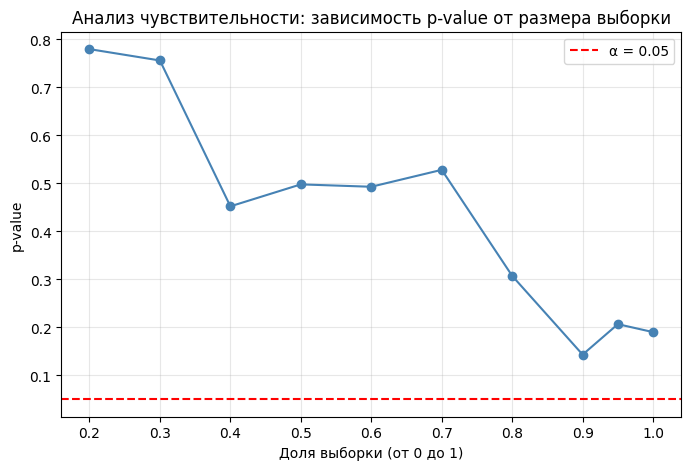

In [852]:
plt.figure(figsize=(8, 5))

plt.plot(sizes, p_values, marker='o', linestyle='-', color='steelblue')
plt.axhline(0.05, color='red', linestyle='--', label='α = 0.05')

plt.title("Анализ чувствительности: зависимость p-value от размера выборки")
plt.xlabel("Доля выборки (от 0 до 1)")
plt.ylabel("p-value")

plt.grid(True, alpha=0.3)
plt.legend()
plt.show()

Факт 1. Группы A и B действительно одинаковы

Иначе при увеличении размера выборки p-value ушло бы ниже 0.05.

Факт 2. Результат A/B теста надёжный

Если бы эффект существовал, график выглядел бы так:
	•	начиная примерно с 40–60% p-value упало бы ниже 0.05
	•	и оставалось бы низким

наоборот: эффекта нет, и это стабильно.